In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 1. Automatic Differentiation with `torch.autograd`

Before proceeding with autograd, will understand the basic terms:

- **Forward Propagation**:
  - Computes the model's output by passing the input data through the network layers. It is often called Forward pass.

- **Backward Propagation**:
  - Calculates the gradients of the loss with respect to the model's parameters using the chain rule, enabling parameter updates to minimize the loss.

### 1.1 ```torch.autograd```



- We create two tensors `x` and `y` with `requires_grad=True`, indicating that we want to compute gradients for these tensors.



- We perform simple operations on `x` and `y` to obtain `z`.

- Computing Gradients:
We call `z.backward()` to compute the gradients of `z` with respect to `x` and `y`. The gradients are stored in the `grad` attribute of each tensor.




In the following example:


- The operation is $ z = x \cdot y + y^2 $.
- The partial derivative of $ z $ with respect to $ x $ is $ \frac{\partial z}{\partial x} = y $.
- The partial derivative of $ z $ with respect to $ y $ is $ \frac{\partial z}{\partial y} = x + 2y $.

Given $ x = 2.0 $ and $ y = 3.0 $:

- The gradient of $ z $ w.r.t. $ x $ is $ 3.0 $.
- The gradient of $ z $ w.r.t. $ y $ is $ 2.0 + 2 \cdot 3.0 = 8.0 $.

Tensors that require gradients will have their operations tracked by PyTorch's autograd engine, enabling the computation of gradients during backpropagation.


<img src=https://learnopencv.com/wp-content/uploads/2024/07/Autograd-Computation-Graph-2-2.png height = 500>


The automatic differentiation provided by `torch.autograd` simplifies this process by handling the complex chain rule calculations needed for backpropagation through the entire network.






For $\frac{\partial z}{\partial x}$:

$$\frac{\partial z}{\partial x} = \frac{\partial z}{\partial p} \frac{\partial p}{\partial x} + \frac{\partial z}{\partial q} \frac{\partial q}{\partial x} = 1 \cdot y + 1 \cdot 0 = y$$

For $\frac{\partial z}{\partial y}$:

$$\frac{\partial z}{\partial y} = \frac{\partial z}{\partial p} \frac{\partial p}{\partial y} + \frac{\partial z}{\partial q} \frac{\partial q}{\partial y} = 1 \cdot x + 1 \cdot 2y = x + 2y$$

These equations correspond to the chain rule calculations happening behind the scenes, demonstrating how PyTorch's autograd system computes gradients through the computational graph.

In [21]:
# Create tensors with requires_grad=True
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = torch.tensor([[4.0], [5.0]], requires_grad=True)

# Perform some operations
z = x * y + y**2

z.retain_grad()  # Retain gradients for z

z.backward(gradient=torch.ones_like(z))  # Specify a gradient for z
# Compute the gradients
z_sum = z.sum()
# Retain gradients for z_sum
z_sum.retain_grad()
# Perform backward pass on z_sum
z_sum.backward()

print(z)
print(z_sum)
print(f"Gradient of x: {x.grad}")
print(f"Gradient of y: {y.grad}")
print(f"Gradient of z: {z.grad}")
print(f"Gradient of z_sum: {z_sum.grad}")
print(f"Result of the operation: z = {z.detach()}")

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
x, y, x.shape, y.shape, (x * y).shape, x*y

(tensor([1., 2., 3.], requires_grad=True),
 tensor([[4.],
         [5.]], requires_grad=True),
 torch.Size([3]),
 torch.Size([2, 1]),
 torch.Size([2, 3]),
 tensor([[ 4.,  8., 12.],
         [ 5., 10., 15.]], grad_fn=<MulBackward0>))

In [11]:
y**2

tensor([[16.],
        [25.]], grad_fn=<PowBackward0>)

### 1.2 Gradient Computation Graph

## 1.2. Gradient Computation Graph


A computation graph is a visual representation of the sequence of operations performed on tensors in a neural network, showing how each operation contributes to the final result. It is crucial for understanding and debugging the flow of data and gradients in deep learning models.

[torchviz](https://github.com/szagoruyko/pytorchviz) is a tool used to visualize the computation graph of any PyTorch model.


<img src=https://learnopencv.com/wp-content/uploads/2024/07/Autograd-Operators-Graph-1-1.png height = 500 >


In [5]:
from torchviz import make_dot
# Visualize the computation graph
dot = make_dot(z, params={"x": x, "y": y, "z": z})
dot.render("grad_computation_graph", format="png")

'grad_computation_graph.png'

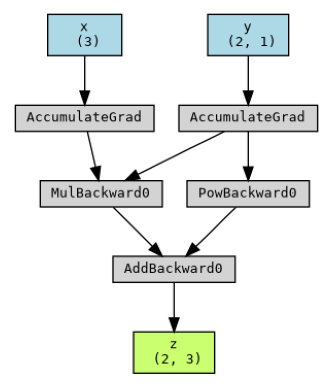

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

# Display the saved image
img = Image.open("grad_computation_graph.png")
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## 1.3. Detaching Tensors from Computation Graph

The `detach()` method is used to create a new tensor that shares storage with the original tensor but without tracking operations. When you call `detach()`, it returns a new tensor that does not require gradients. This is useful when you want to perform operations on a tensor without affecting the computation graph.

In [9]:
# Let's detach tensor (z) from the computation graph
print(f'Before detaching z from computation graph, requires_grad param: {z.requires_grad}')
z_detached = z.detach()
print(f'After detaching z from computation graph, requires_grad param: {z_detached.requires_grad}')

Before detaching z from computation graph, requires_grad param: True
After detaching z from computation graph, requires_grad param: False


###  1.4. Can Backpropagation be performed when `requires_grad=False`?

Now the same tensors $x$ and $y$ are created with `requires_grad=False`.

When attempting to compute the gradients using `z.backward()`, a **RuntimeError** is raised because the tensors do not require gradients, and thus do not have a `grad_fn`.

In this case, since `requires_grad=False` was used, the computation graph is essentially empty, as no gradients will be tracked.

In [12]:
try:
    x = torch.tensor([1.0, 2.0, 3.0], requires_grad=False)
    y = torch.tensor([[4.0], [5.0]], requires_grad=False)

    z = x * y + y**2

    # Compute the gradients again
    z.backward()  # This will not compute gradients since requires_grad=False
except RuntimeError as e:
    print(f"Error encountered: {e}")
finally:
    # Detach x and y from the computation graph
    x = x.detach()
    y = y.detach()
    print(f"Gradient of x after detaching: {x.grad}")
    print(f"Gradient of y after detaching: {y.grad}")

Error encountered: element 0 of tensors does not require grad and does not have a grad_fn
Gradient of x after detaching: None
Gradient of y after detaching: None


# 2. Backpropagation in Neural Networks

<img src=https://learnopencv.com/wp-content/uploads/2017/10/gradient-descent-2d-diagram.png>

We have understood the mathematical intuition behind and how **torch.autograd** takes care of automatic differentiation with an example.

Then,
 * The loss is calculated between prediction and target using `loss(predcition,target)`
 * Then backpropagation is performed using `loss.backward()`
 * We update the new weights using `optimizer.step()`

<img src=https://learnopencv.com/wp-content/uploads/2023/01/keras-linear-regression-weight-update-block-diagram.png>


**The Weight Update Formula is:**


$$ \mathbf{w}_{\text{new}} = \mathbf{w} - \eta \nabla L(\mathbf{w}) $$

The gradient of $ L $ is a vector of partial derivatives:

$$ \nabla L = \left( \frac{\partial L}{\partial w_1}, \frac{\partial L}{\partial w_2}, \ldots, \frac{\partial L}{\partial w_n} \right) $$

- **Current Weights $( \mathbf{w} )$**: These are the weights of the model before the update.
- **Learning Rate $( \eta )$**: A hyperparameter that controls the step size of the weight update. A smaller learning rate makes the training process slower but more precise, while a larger learning rate makes the training process faster but it may sometimes overshoot the optimal solution.
- **Gradient of the Loss $( \nabla L(\mathbf{w}) )$**: The partial derivatives of the loss function with respect to each weight. This indicates the direction and magnitude of the steepest ascent in the loss function.
- **Updated Weights $(\mathbf{w}_{\text{new}} )$**: The new weights after applying the gradient descent step.


After applying the updates, it's crucial to zero out the gradients. This is typically done using: `optimizer.zero_grad()`



Interesting, right? This is how the model learns. During training, the model iteratively adjusts its weights and biases to minimize the loss function, which measures the difference between the predicted outputs and the actual targets.

This process of forward pass, gradient computation, backward pass, and parameter update is repeated for many iterations (epochs) over the entire dataset. With each iteration, the model's parameters are refined, gradually reducing the loss and improving the model's performance.

In our upcoming notebooks we will understand all these concepts with hands on training.

# 3. Conclusion

We learnt how the gradients are updated mathematically with a node graph diagrams. We also visualized the computation graph using torchviz, providing a clear understanding of how operations are structured in PyTorch. Finally, we understood how weight updates happen during training with code, illustrating the core mechanism of model learning.

In [15]:
help(torch.Tensor.backward)

Help on function backward in module torch._tensor:

backward(self, gradient=None, retain_graph=None, create_graph=False, inputs=None)
    Computes the gradient of current tensor wrt graph leaves.

    The graph is differentiated using the chain rule. If the tensor is
    non-scalar (i.e. its data has more than one element) and requires
    gradient, the function additionally requires specifying a ``gradient``.
    It should be a tensor of matching type and shape, that represents
    the gradient of the differentiated function w.r.t. ``self``.

    This function accumulates gradients in the leaves - you might need to zero
    ``.grad`` attributes or set them to ``None`` before calling it.
    See :ref:`Default gradient layouts<default-grad-layouts>`
    for details on the memory layout of accumulated gradients.

    .. note::

        If you run any forward ops, create ``gradient``, and/or call ``backward``
        in a user-specified CUDA stream context, see
        :ref:`Stream semant